Wheelchair kinetics
===================

The [pushrimkinetics](api/kineticstoolkit.pushrimkinetics.rst) module allows processing kinetics data from instrumented wheelchair wheels such as the SmartWheel.

In [1]:
import kineticstoolkit.lab as ktk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Read data from file
-------------------
The first step is to load data from a file, using the [ktk.pushrimkinetics.read_file()](api/kineticstoolkit.pushrimkinetics.rst#kineticstoolkit.pushrimkinetics.read_file) function.

In [2]:
filename = ('data/pushrimkinetics/'
            'sample_swl_overground_propulsion_withrubber.csv')

kinetics = ktk.pushrimkinetics.read_file(filename, file_format='smartwheel')

Let see what we loaded:

In [3]:
kinetics

TimeSeries with attributes:
             data: <dict with 5 entries>,
        data_info: <dict with 4 entries>,
           events: <list of 0 items>,
             time: <array of shape (7682,)>,
        time_info: <dict with 1 entries>

In [4]:
kinetics.data

{
         'Angle': <array of shape (7682,)>,
      'Channels': <array of shape (7682, 6)>,
        'Forces': <array of shape (7682, 4)>,
         'Index': <array of shape (7682,)>,
       'Moments': <array of shape (7682, 4)>
}

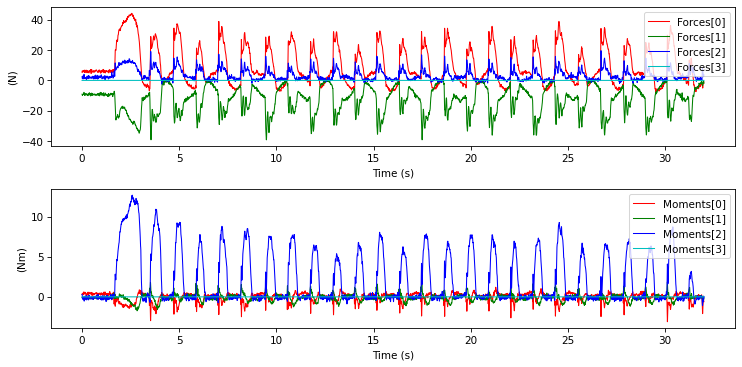

In [5]:
plt.subplot(2, 1, 1)
kinetics.plot('Forces')
plt.subplot(2, 1, 2)
kinetics.plot('Moments')
plt.tight_layout()

Calculate forces and moments
----------------------------
If the loaded data doesn't include forces and moments but only raw data (for exemple, when loading data from a SmartWheel's SD card), we must calculate the forces and moments based on a calibration matrix. The function [ktk.pushrimkinetics.calculate_forces_and_moments()](api/kineticstoolkit.pushrimkinetics.rst#kineticstoolkit.pushrimkinetics.calculate_forces_and_moments) performs this calculation. In this example, we use a calibration matrix that is included in `ktk.pushrimkinetics.CALIBRATION_MATRICES`, and we express the calculated forces and moments in a reference frame that is orthogonal to the ground (levelled using the wheel's angular encoder).

In [6]:
calibration_matrices = ktk.pushrimkinetics.CALIBRATION_MATRICES['SmartWheel_123']
calibration_matrices

{
           'gains': <array of shape (6,)>,
         'offsets': <array of shape (6,)>,
      'transducer': 'smartwheel'
}

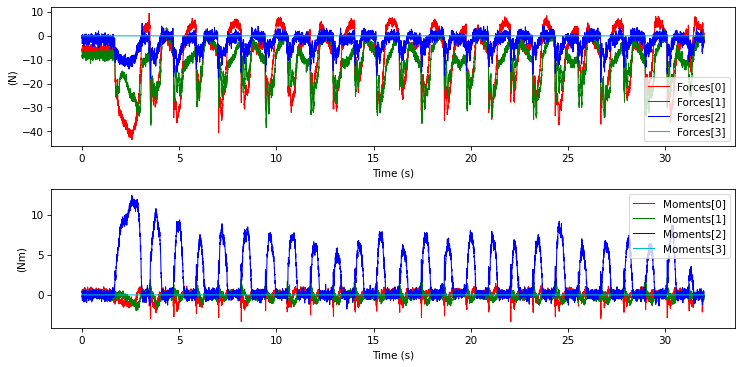

In [7]:
new_kinetics = ktk.pushrimkinetics.calculate_forces_and_moments(
    kinetics,
    gains=calibration_matrices['gains'],
    offsets=calibration_matrices['offsets'],
    transducer='smartwheel',
    reference_frame='hub')

plt.subplot(2, 1, 1)
new_kinetics.plot('Forces')
plt.subplot(2, 1, 2)
new_kinetics.plot('Moments')
plt.tight_layout()

We observe some sign differences here. In fact, the SmartWheel softwares inverts some signals based on the SmartWheel's sign convention and the side of the wheel. When the forces and moments are reconstructed from raw data, these sign changes do not happen, which explains these discrepancies.

Removing dynamic offsets in forces and moments
----------------------------------------------
We observe in the last graphs that dynamic (sinusoidal) offsets are presents mostly in the forces but also in the moments. We can auto-remove these offsets using [ktk.pushrimkinetics.remove_offsets()](api/kineticstoolkit.pushrimkinetics.rst#kineticstoolkit.pushrimkinetics.remove_offsets).

Let's apply this function on the data we just loaded.

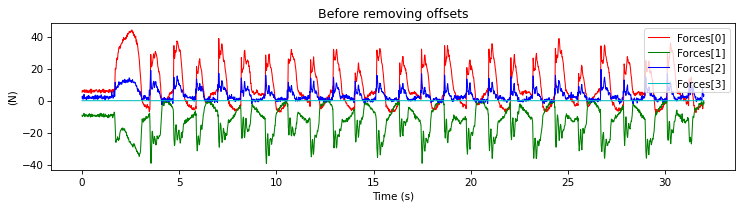

In [8]:
plt.subplot(2, 1, 1)
kinetics.plot('Forces')
plt.title('Before removing offsets')
plt.tight_layout()

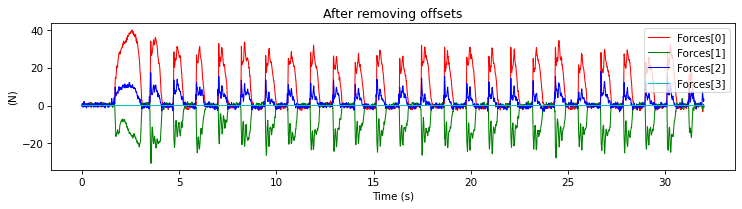

In [9]:
kinetics = ktk.pushrimkinetics.remove_offsets(kinetics)

plt.subplot(2, 1, 2)
kinetics.plot('Forces')
plt.title('After removing offsets')
plt.tight_layout()

This automatic method has only be validated for straight-line, level-ground propulsion. For any other condition, a baseline trial is required. A baseline trial is a trial where an operator pushes the wheelchair but no external force appart from gravity is applied on the instrumented wheel. Please consult the [ktk.pushrimkinetics.remove_offsets](api/kineticstoolkit.pushrimkinetics.rst#kineticstoolkit.pushrimkinetics.remove_offsets) help for more information.

Calculate velocity and power
----------------------------
Thee wheel velocity is calculated from the wheel angle with a derivative Savitsky-Golay filter, using the [ktk.pushrimkinetics.calculate_velocity()](api/kineticstoolkit.pushrimkinetics.rst#kineticstoolkit.pushrimkinetics.calculate_velocity) function. Once the velocity has been calculated, the output power can also be calculated by
multiplying the velocity by the propulsion moment, using the [ktk.pushrimkinetics.calculate_power()](api/kineticstoolkit.pushrimkinetics.rst#kineticstoolkit.pushrimkinetics.calculate_power) function.

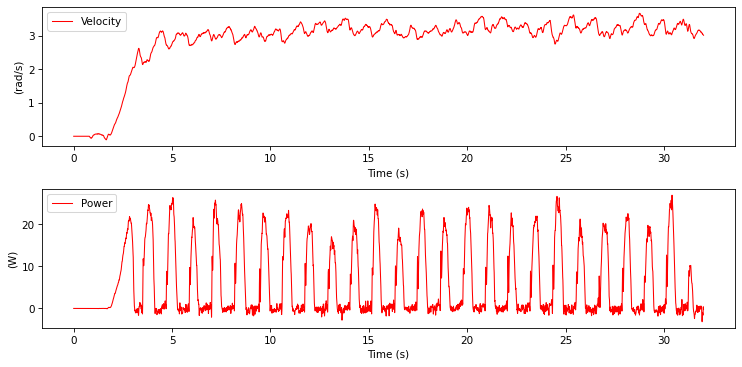

In [10]:
kinetics = ktk.pushrimkinetics.calculate_velocity(kinetics)
kinetics = ktk.pushrimkinetics.calculate_power(kinetics)

plt.subplot(2, 1, 1)
kinetics.plot('Velocity')
plt.subplot(2, 1, 2)
kinetics.plot('Power')
plt.tight_layout()

Detecting the pushes
--------------------

The [kineticstoolkit.cycles](cycles.rst) module provides powerful tools to detect and manage cycles. Here we use [ktk.cycles.detect_cycles](api/kineticstoolkit.cycles.rst#kineticstoolkit.cycles.detect_cycles) to detect the pushes using these specifications:
- a push starts when the total force crosses 5 N upward;
- a push ends when the total force crosses 2 N downward;
- for a push to be valid, it must last at least 100 ms;
- to be valid, the total force must reach 25 N.

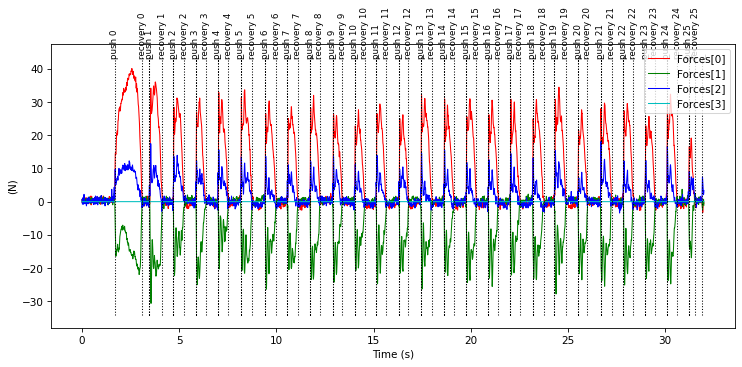

In [11]:
# Create the total force data
kinetics.data['Ftot'] = np.sqrt(np.sum(kinetics.data['Forces'] ** 2, axis=1))

kinetics = ktk.cycles.detect_cycles(
    kinetics, 'Ftot',
    event_name1='push',
    event_name2='recovery',
    threshold1=5.0,
    threshold2=2.0,
    min_duration1=0.1,
    min_peak_height1=25.0
)

kinetics.plot('Forces')
plt.tight_layout()

Extracting spatiotemporal and kinetic parameters
------------------------------------------------

As a conclusion to this tutorial, we will now extract some key spatiotemporal and kinetic parameters from these data, and express those parameters as a pandas DataFrame. Obviously, this is only an example and many other parameters can be calculated using a similar procedure.

In [12]:
n_cycles = 15  # Number of cycles to analyze

records = []  # Init a list that will contains the results of the analysis

for i_cycle in range(n_cycles):
    
    # Get a TimeSeries that spans only the push i_push
    ts_push = kinetics.get_ts_between_events('push', 'recovery', i_cycle, i_cycle)
    
    # Get a TimeSeries that spans the entire cycle i_push
    ts_cycle = kinetics.get_ts_between_events('push', '_', i_cycle, i_cycle)
    
    # Get some spatiotemporal parameters
    push_time = ts_push.time[-1] - ts_push.time[0]
    cycle_time = ts_cycle.time[-1] - ts_cycle.time[0]
    recovery_time = cycle_time - push_time

    push_angle = ts_push.data['Angle'][-1] - ts_push.data['Angle'][0]
    
    # Get some kinetic parameters
    propulsion_moment_mean = np.mean(ts_push.data['Moments'][:, 2])
    propulsion_moment_max = np.max(ts_push.data['Moments'][:, 2])
    
    total_force_mean = np.mean(ts_push.data['Ftot'])
    total_force_max = np.max(ts_push.data['Ftot'])
    
    # Record this information in the records list
    records.append({
        'Push time (s)': push_time,
        'Recovery time (s)': recovery_time,
        'Cycle time (s)': cycle_time,
        'Push angle (deg)': np.rad2deg(push_angle),
        'Mean propulsion moment (Nm)': propulsion_moment_mean,
        'Max propulsion moment (Nm)': propulsion_moment_max,
        'Mean total force (N)': total_force_mean,
        'Max total force (N)': total_force_max,
    })

# Create and show a DataFrame of this information
df = pd.DataFrame.from_dict(records)

# Copy the dataframe to the clipboard for pasting into Excel (facultative)
df.to_clipboard()

# Print the dataframe here
df

,Push time (s),Recovery time (s),Cycle time (s),Push angle (deg),Mean propulsion moment (Nm),Max propulsion moment (Nm),Mean total force (N),Max total force (N)
0,1.404167,0.358333,1.762500,75.85,9.106452,12.716142,34.117531,44.257457
1,0.654167,0.579167,1.233333,88.33,6.992656,11.005038,30.669055,47.699743
2,0.554167,0.583333,1.137500,88.51,6.244814,9.327931,25.279054,37.581425
3,0.495833,0.633333,1.129167,79.80,4.328190,7.851847,23.573272,39.199059
4,0.533333,0.629167,1.162500,90.70,5.271423,8.831854,22.133097,40.147530
5,0.587500,0.675000,1.262500,97.12,5.611598,8.544609,25.567489,41.677356
6,0.550000,0.570833,1.120833,93.60,4.906104,7.642254,23.327076,37.582148
7,0.537500,0.637500,1.175000,90.00,5.233192,7.801526,23.085664,36.135763
8,0.487500,0.654167,1.141667,86.13,4.663521,6.557192,25.296090,40.663234
9,0.479167,0.658333,1.137500,87.18,3.506395,5.401392,21.393315,35.221362


For more information, please check the [API Reference for the pushrimkinetics module](api/kineticstoolkit.pushrimkinetics.rst).